In [1]:
import sys, os

src = r"C:\Users\user\Desktop\Coding mo\AutoML proj1\task 1\AutoML Project Molham\src" # copy the location of the folder that has paths.py file using (ctrl + shift + C ) and paste it here    
sys.path.append(src)

from paths import *

get_paths()

sys.path.append(SRC_PATH)


from boosting_models import *
from pipeline import *


In [2]:
# ---------------- Task 2+9 ----------------

from xgboost import XGBClassifier, plot_importance as xgb_plot_importance

def loop_dfs_and_evaluate_xgboost():
    for dataset_file in data_dict_classification_only.keys():
        dataset_summary = []
        runtime_memory_rows = []
        dataset_base = os.path.splitext(dataset_file)[0]

        for seed in RANDOM_SEEDS:
            np.random.seed(seed)
            random.seed(seed)

            df_train = splits_dict[dataset_file]['train']
            df_test = splits_dict[dataset_file]['test']
            target_col = TARGET_COLS[dataset_file]

            X_train = df_train.drop(columns=[target_col])
            y_train = df_train[target_col]
            X_test = df_test.drop(columns=[target_col])
            y_test = df_test[target_col]

            start_time = time.time()
            model = XGBClassifier(
                random_state=seed,
                n_estimators=300,
                learning_rate=0.1,
                max_depth=6,
                subsample=0.8,
                colsample_bytree=0.8,
                use_label_encoder=False,
                eval_metric='logloss',
                enable_categorical=True

            )
            model.fit(X_train, y_train)
            training_runtime_sec = round(time.time() - start_time, 3)

            temp_model_file = os.path.join("temp_xgb_models", f"{dataset_base}_{seed}.pkl")
            os.makedirs("temp_xgb_models", exist_ok=True)
            with open(temp_model_file, "wb") as f:
                pickle.dump(model, f)
            total_bytes = os.path.getsize(temp_model_file)
            model_size_mb = round(total_bytes / (1024 * 1024), 3)
            os.remove(temp_model_file)

            memory_usage_mb = get_memory_usage_mb()

            results = evaluate_and_save_results_boosting(df_train, df_test, model, dataset_file)

            runtime_memory_rows.append({
                "dataset": dataset_file,
                "seed": seed,
                "training_runtime_sec": training_runtime_sec,
                "model_size_MB": model_size_mb,
                "memory_usage_MB": memory_usage_mb
            })

            dataset_summary.append({
                'dataset': dataset_file,
                'seed': seed,
                **results,
                'runtime': training_runtime_sec
            })

            del model
            gc.collect()

        output_path = os.path.join(BOOSTINGS_PATH, f"xgboost_{dataset_base}_summary.csv")
        pd.DataFrame(dataset_summary).to_csv(output_path, index=False)

        task2_output_path = os.path.join(RUNTIME_MEMORY_TASK2_BOOSTINGS_PATH, f"xgboost_{dataset_base}_task2_runtime_memory_metrics.csv")
        pd.DataFrame(runtime_memory_rows).to_csv(task2_output_path, index=False)


loop_dfs_and_evaluate_xgboost()





In [3]:
for dataset_name in data_dict_classification_only.keys():
    dataset_base = dataset_name.replace('.csv', '')
    
    csv_file1 = os.path.join(BOOSTINGS_PATH, f"xgboost_{dataset_base}_summary.csv")
    csv_file2 = os.path.join(RUNTIME_MEMORY_TASK2_BOOSTINGS_PATH, f"xgboost_{dataset_base}_task2_runtime_memory_metrics.csv")

    print(f"CSV for {dataset_name.replace('.csv', '')}: xgboost_{dataset_base}_summary.csv")
    df1 = pd.read_csv(csv_file1)
    display(df1)

    print(f"CSV for {dataset_name.replace('.csv', '')}: xgboost_{dataset_base}_task1_runtime_memory_metrics.csv")
    df2 = pd.read_csv(csv_file2)
    display(df2)



CSV for modeldata: xgboost_modeldata_summary.csv


,dataset,seed,accuracy,f1,precision,recall,runtime
0,modeldata.csv,42,0.931797,0.931973,0.932283,0.931797,2.764
1,modeldata.csv,123,0.931890,0.932098,0.932501,0.931890,2.586


CSV for modeldata: xgboost_modeldata_task1_runtime_memory_metrics.csv


,dataset,seed,training_runtime_sec,model_size_MB,memory_usage_MB
0,modeldata.csv,42,2.764,0.758,7746.602
1,modeldata.csv,123,2.586,0.768,7775.598


CSV for titanic: xgboost_titanic_summary.csv


,dataset,seed,accuracy,f1,precision,recall,runtime
0,titanic.csv,42,0.793296,0.793495,0.793744,0.793296,0.171
1,titanic.csv,123,0.776536,0.776060,0.775781,0.776536,0.157


CSV for titanic: xgboost_titanic_task1_runtime_memory_metrics.csv


,dataset,seed,training_runtime_sec,model_size_MB,memory_usage_MB
0,titanic.csv,42,0.171,1.186,7280.375
1,titanic.csv,123,0.157,1.217,7282.102


CSV for train: xgboost_train_summary.csv


,dataset,seed,accuracy,f1,precision,recall,runtime
0,train.csv,42,1.0,1.0,1.0,1.0,0.059
1,train.csv,123,1.0,1.0,1.0,1.0,0.075


CSV for train: xgboost_train_task1_runtime_memory_metrics.csv


,dataset,seed,training_runtime_sec,model_size_MB,memory_usage_MB
0,train.csv,42,0.059,0.678,7286.461
1,train.csv,123,0.075,0.680,7287.316


CSV for wine: xgboost_wine_summary.csv


,dataset,seed,accuracy,f1,precision,recall,runtime
0,wine.csv,42,1.0,1.0,1.0,1.0,0.095
1,wine.csv,123,1.0,1.0,1.0,1.0,0.090


CSV for wine: xgboost_wine_task1_runtime_memory_metrics.csv


,dataset,seed,training_runtime_sec,model_size_MB,memory_usage_MB
0,wine.csv,42,0.095,0.645,7287.922
1,wine.csv,123,0.090,0.643,7288.051


In [4]:
# ---------------- Task 2+9 ----------------

from xgboost import XGBClassifier, plot_importance as xgb_plot_importance

def loop_dfs_and_evaluate_xgboost_tuned():
    for dataset_file in data_dict_classification_only.keys():

        dataset_summary = []
        runtime_memory_rows = []
        dataset_base = dataset_file.replace(".csv", "")

        for seed in RANDOM_SEEDS:
            np.random.seed(seed)
            random.seed(seed)

            df_train = splits_dict[dataset_file]['train']
            df_test = splits_dict[dataset_file]['test']
            target_col = TARGET_COLS[dataset_file]

            X_train = df_train.drop(columns=[target_col])
            y_train = df_train[target_col]
            X_test = df_test.drop(columns=[target_col])
            y_test = df_test[target_col]

            model = XGBClassifier(
                random_state=seed,
                use_label_encoder=False,
                eval_metric='logloss',
                enable_categorical=True,
                n_jobs=-1
            )

            search = RandomizedSearchCV(
                model,
                param_distributions=param_grid,
                n_iter=10,
                scoring='accuracy',
                cv=3,
                random_state=seed,
                n_jobs=-1,
                verbose=0
            )

            start_time = time.time()
            search.fit(X_train, y_train)
            training_runtime_sec = round(time.time() - start_time, 3)

            best_model = search.best_estimator_
            best_params = search.best_params_

            infer_start = time.time()
            results = evaluate_and_save_results_boosting(
                df_train, df_test, best_model, dataset_file
            )
            inference_runtime_sec = round(time.time() - infer_start, 6)

            temp_model_dir = "temp_xgboost_tuned_models"
            os.makedirs(temp_model_dir, exist_ok=True)
            temp_model_file = os.path.join(temp_model_dir, f"{dataset_base}_{seed}.pkl")

            with open(temp_model_file, "wb") as f:
                pickle.dump(best_model, f)

            total_bytes = os.path.getsize(temp_model_file)
            model_size_mb = round(total_bytes / (1024 * 1024), 3)
            os.remove(temp_model_file)

            memory_usage_mb = get_memory_usage_mb()
            cpu_usage_percent = psutil.cpu_percent(interval=None)

            dataset_summary.append({
                "dataset": dataset_file,
                "seed": seed,
                **results,
                "training_runtime_sec": training_runtime_sec,
                "inference_runtime_sec": inference_runtime_sec,
                "best_params": str(best_params)
            })

            runtime_memory_rows.append({
                "dataset": dataset_file,
                "seed": seed,
                "training_runtime_sec": training_runtime_sec,
                "model_size_MB": model_size_mb,
                "memory_usage_MB": memory_usage_mb,
                "inference_time_per_sample_sec": inference_runtime_sec / len(X_test),
                "cpu_usage_percent": cpu_usage_percent
            })

            feature_importances = best_model.get_booster().get_score(importance_type='gain')
            importance_df = (
                pd.DataFrame({
                    'feature': list(feature_importances.keys()),
                    'importance': list(feature_importances.values())
                })
                .sort_values(by='importance', ascending=False)
                .head(15)
            )

            plt.figure(figsize=(14, 8))
            sns.barplot(data=importance_df, x='importance', y='feature')
            plt.title(f"XGBoost Tuned Feature Importance\n{dataset_file} (seed={seed})")
            plt.tight_layout()

            plot_file = os.path.join(
                FEATURE_IMPORTANCE_PATH,
                f"xgboost_importance_{dataset_base}_seed{seed}.png"
            )
            plt.savefig(plot_file)
            plt.close()

            del X_train, X_test, y_train, y_test, model, search, best_model
            gc.collect()

        output_path = os.path.join(
            BOOSTINGS_TUNED_PATH,
            f"xgboost_tuned_{dataset_base}_summary.csv"
        )
        pd.DataFrame(dataset_summary).to_csv(output_path, index=False)

        task2_output_path = os.path.join(
            RUNTIME_MEMORY_TASK2_BOOSTINGS_TUNED_PATH,
            f"xgboost_tuned_{dataset_base}_runtime_memory_metrics.csv"
        )
        pd.DataFrame(runtime_memory_rows).to_csv(task2_output_path, index=False)

        json_path = os.path.join(
            RUNTIME_MEMORY_TASK2_BOOSTINGS_TUNED_PATH,
            f"xgboost_tuned_{dataset_base}_runtime_memory_metrics_in_json.json"
        )
        with open(json_path, 'w') as f:
            json.dump(runtime_memory_rows, f, indent=2)

loop_dfs_and_evaluate_xgboost_tuned()


CSV for modeldata: xgboost_tuned_modeldata_summary.csv


,dataset,seed,accuracy,f1,precision,recall,training_runtime_sec,inference_runtime_sec,best_params
0,modeldata.csv,42,0.931982,0.932158,0.932472,0.931982,52.223,0.105597,"{'subsample': 1.0, 'n_estimators': 300, 'min_c..."
1,modeldata.csv,123,0.932661,0.932858,0.933231,0.932661,51.710,0.103922,"{'subsample': 0.8, 'n_estimators': 300, 'min_c..."


CSV for modeldata: xgboost_tuned_modeldata_runtime_memory_metrics.csv


,dataset,seed,training_runtime_sec,model_size_MB,memory_usage_MB,inference_time_per_sample_sec,cpu_usage_percent
0,modeldata.csv,42,52.223,0.685,7810.375,0.000003,52.3
1,modeldata.csv,123,51.710,0.721,7821.684,0.000003,67.0


Feature Importance for modeldata (seed=42):


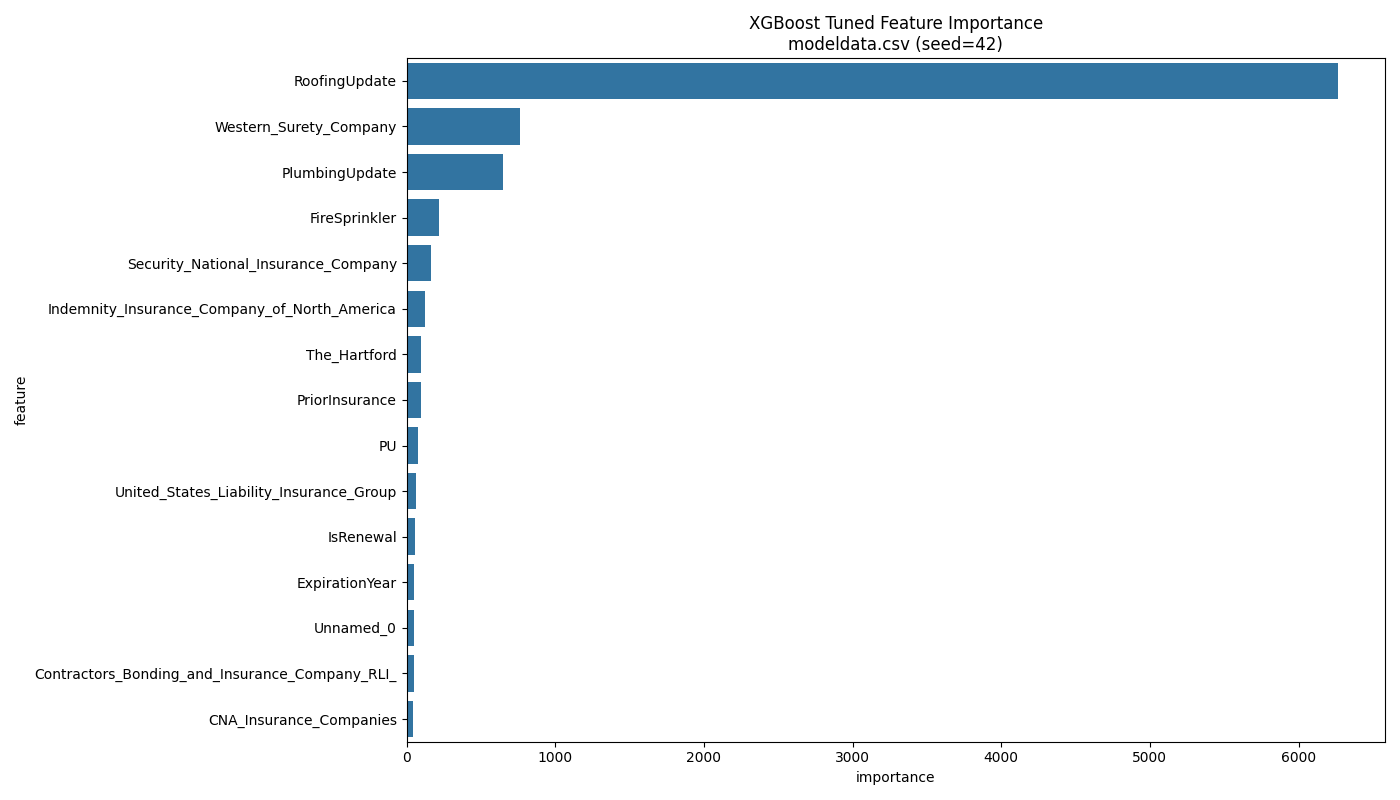

Feature Importance for modeldata (seed=123):


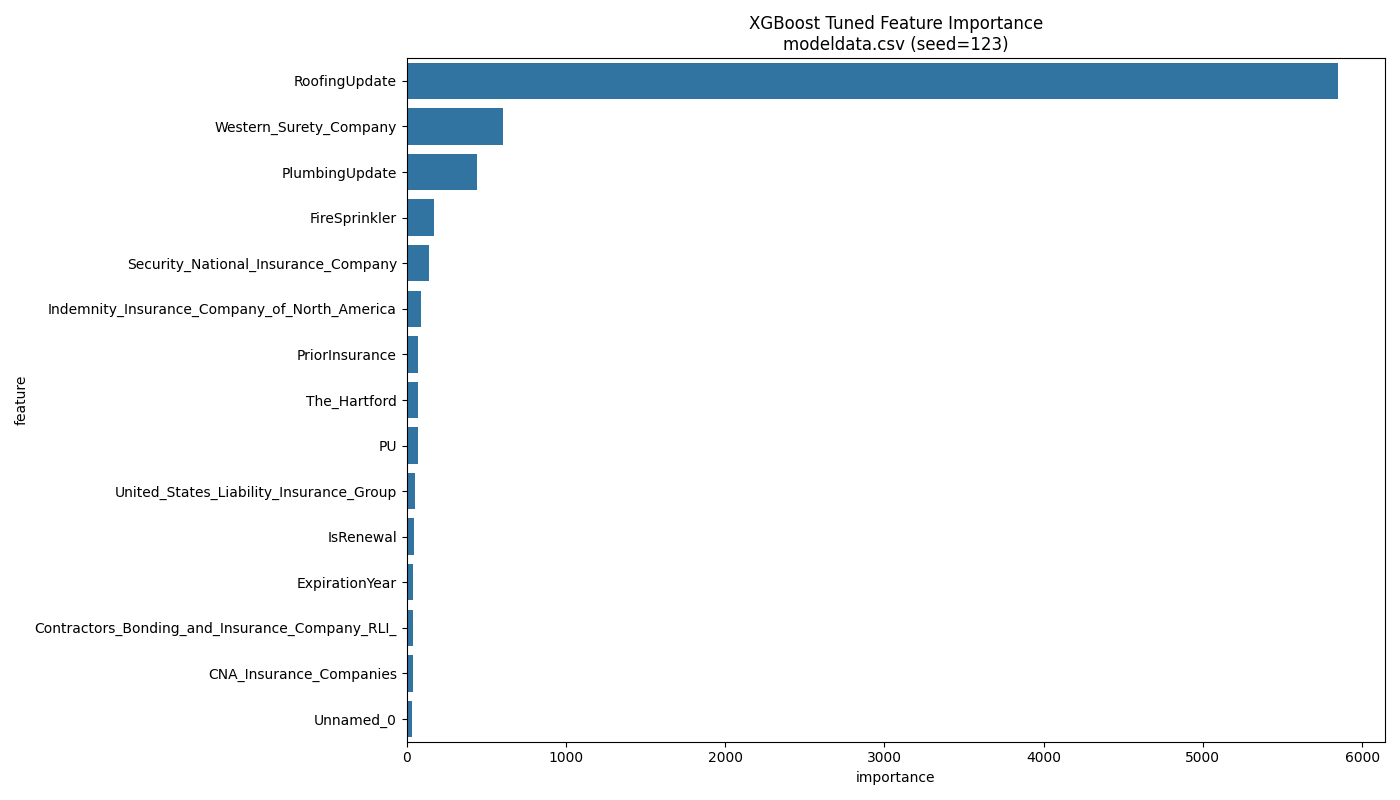

CSV for titanic: xgboost_tuned_titanic_summary.csv


,dataset,seed,accuracy,f1,precision,recall,training_runtime_sec,inference_runtime_sec,best_params
0,titanic.csv,42,0.810056,0.810056,0.810056,0.810056,0.586,0.010510,"{'subsample': 1.0, 'n_estimators': 100, 'min_c..."
1,titanic.csv,123,0.793296,0.792613,0.792387,0.793296,0.695,0.011709,"{'subsample': 0.8, 'n_estimators': 300, 'min_c..."


CSV for titanic: xgboost_tuned_titanic_runtime_memory_metrics.csv


,dataset,seed,training_runtime_sec,model_size_MB,memory_usage_MB,inference_time_per_sample_sec,cpu_usage_percent
0,titanic.csv,42,0.586,0.376,7298.508,0.000059,60.0
1,titanic.csv,123,0.695,1.178,7306.109,0.000065,74.9


Feature Importance for titanic (seed=42):


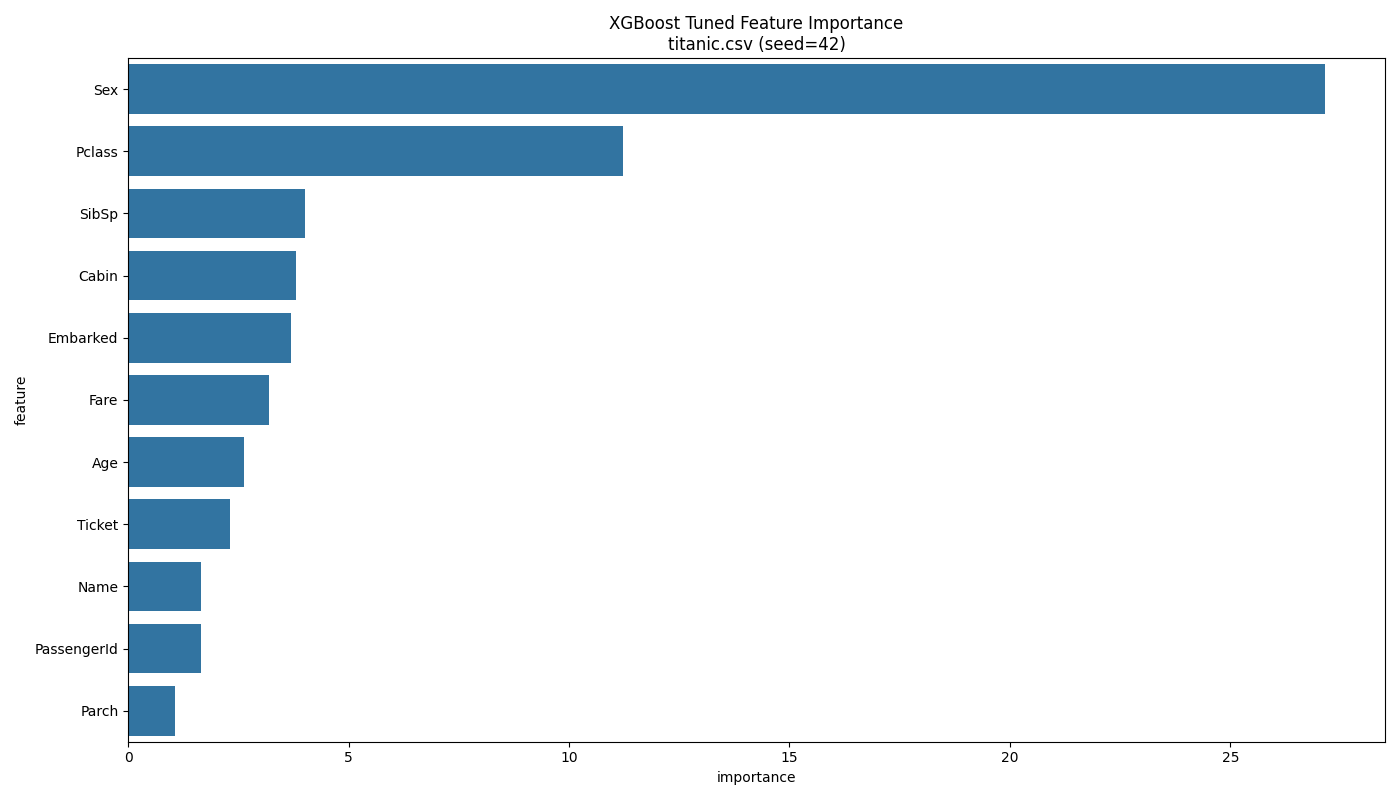

Feature Importance for titanic (seed=123):


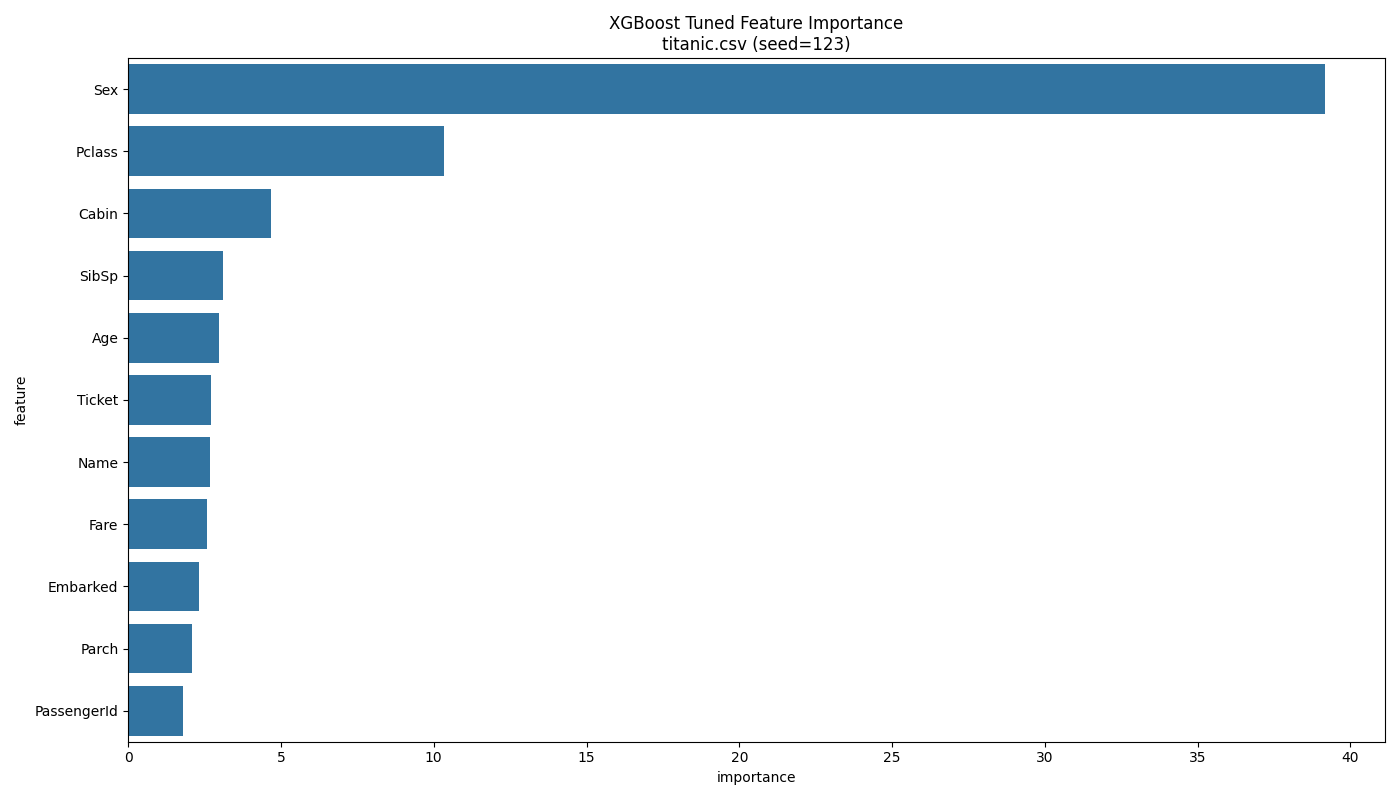

CSV for train: xgboost_tuned_train_summary.csv


,dataset,seed,accuracy,f1,precision,recall,training_runtime_sec,inference_runtime_sec,best_params
0,train.csv,42,1.0,1.0,1.0,1.0,0.192,0.007504,"{'subsample': 1.0, 'n_estimators': 300, 'min_c..."
1,train.csv,123,1.0,1.0,1.0,1.0,0.157,0.006512,"{'subsample': 0.8, 'n_estimators': 100, 'min_c..."


CSV for train: xgboost_tuned_train_runtime_memory_metrics.csv


,dataset,seed,training_runtime_sec,model_size_MB,memory_usage_MB,inference_time_per_sample_sec,cpu_usage_percent
0,train.csv,42,0.192,0.746,7312.621,0.000250,58.1
1,train.csv,123,0.157,0.233,7317.410,0.000217,66.8


Feature Importance for train (seed=42):


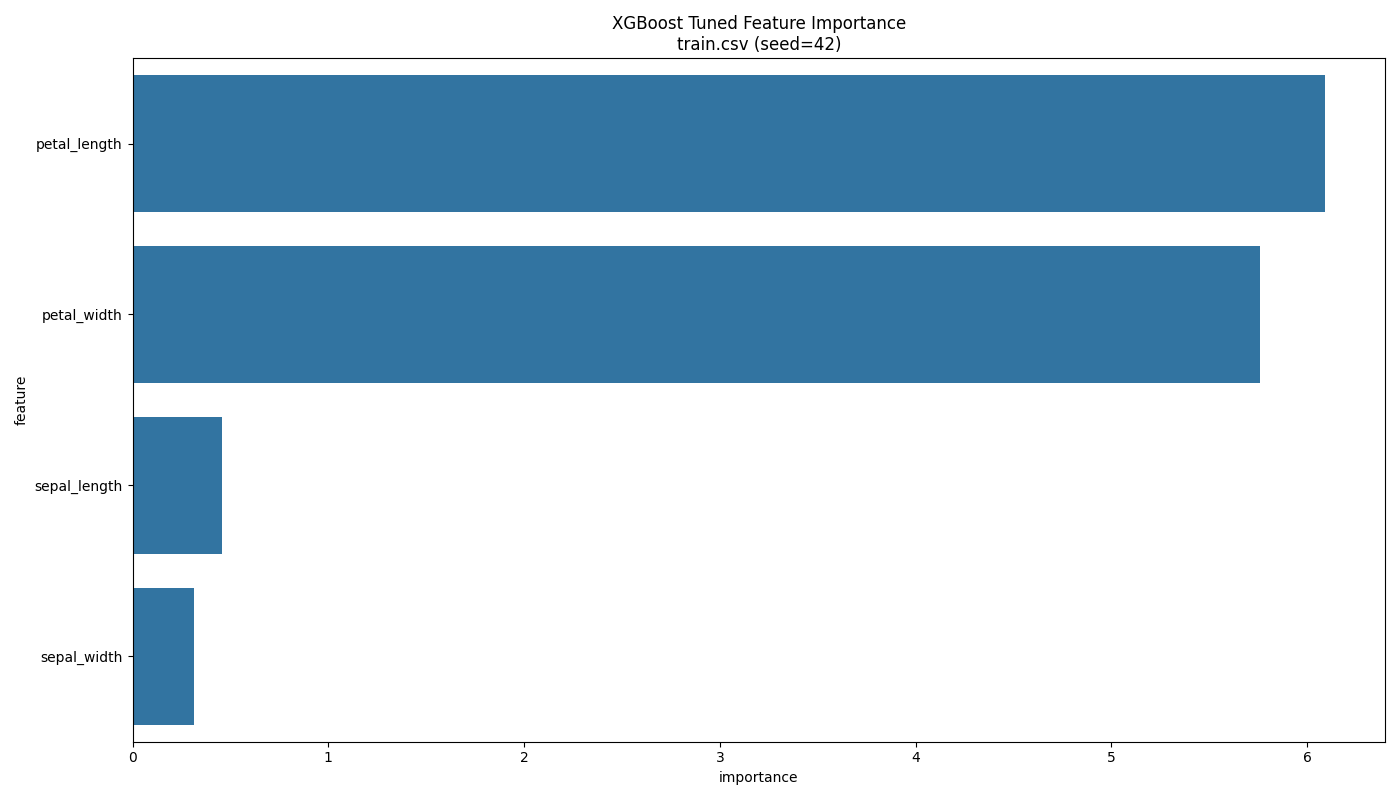

Feature Importance for train (seed=123):


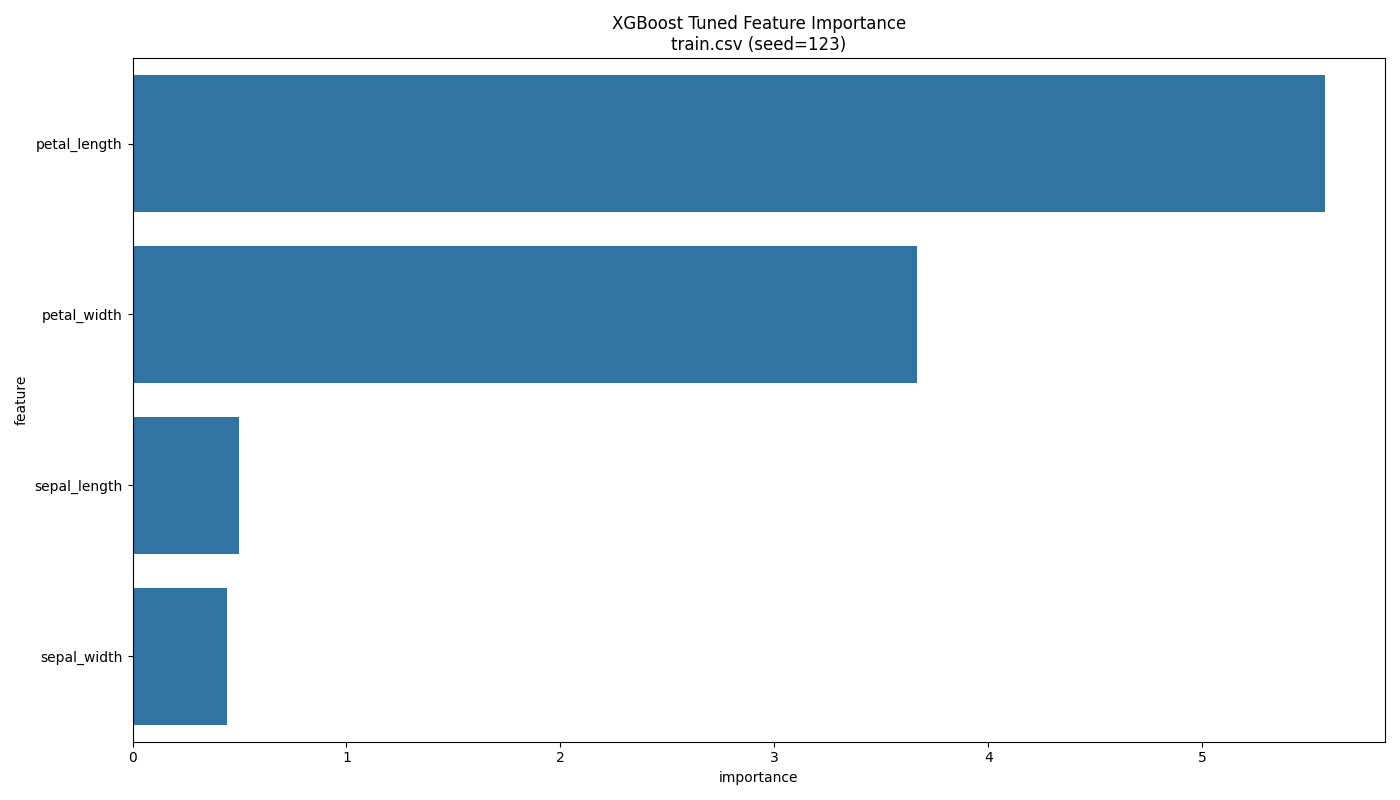

CSV for wine: xgboost_tuned_wine_summary.csv


,dataset,seed,accuracy,f1,precision,recall,training_runtime_sec,inference_runtime_sec,best_params
0,wine.csv,42,1.0,1.0,1.0,1.0,0.245,0.00751,"{'subsample': 0.8, 'n_estimators': 300, 'min_c..."
1,wine.csv,123,1.0,1.0,1.0,1.0,0.236,0.00702,"{'subsample': 1.0, 'n_estimators': 100, 'min_c..."


CSV for wine: xgboost_tuned_wine_runtime_memory_metrics.csv


,dataset,seed,training_runtime_sec,model_size_MB,memory_usage_MB,inference_time_per_sample_sec,cpu_usage_percent
0,wine.csv,42,0.245,0.683,7323.160,0.000209,65.5
1,wine.csv,123,0.236,0.228,7328.262,0.000195,59.2


Feature Importance for wine (seed=42):


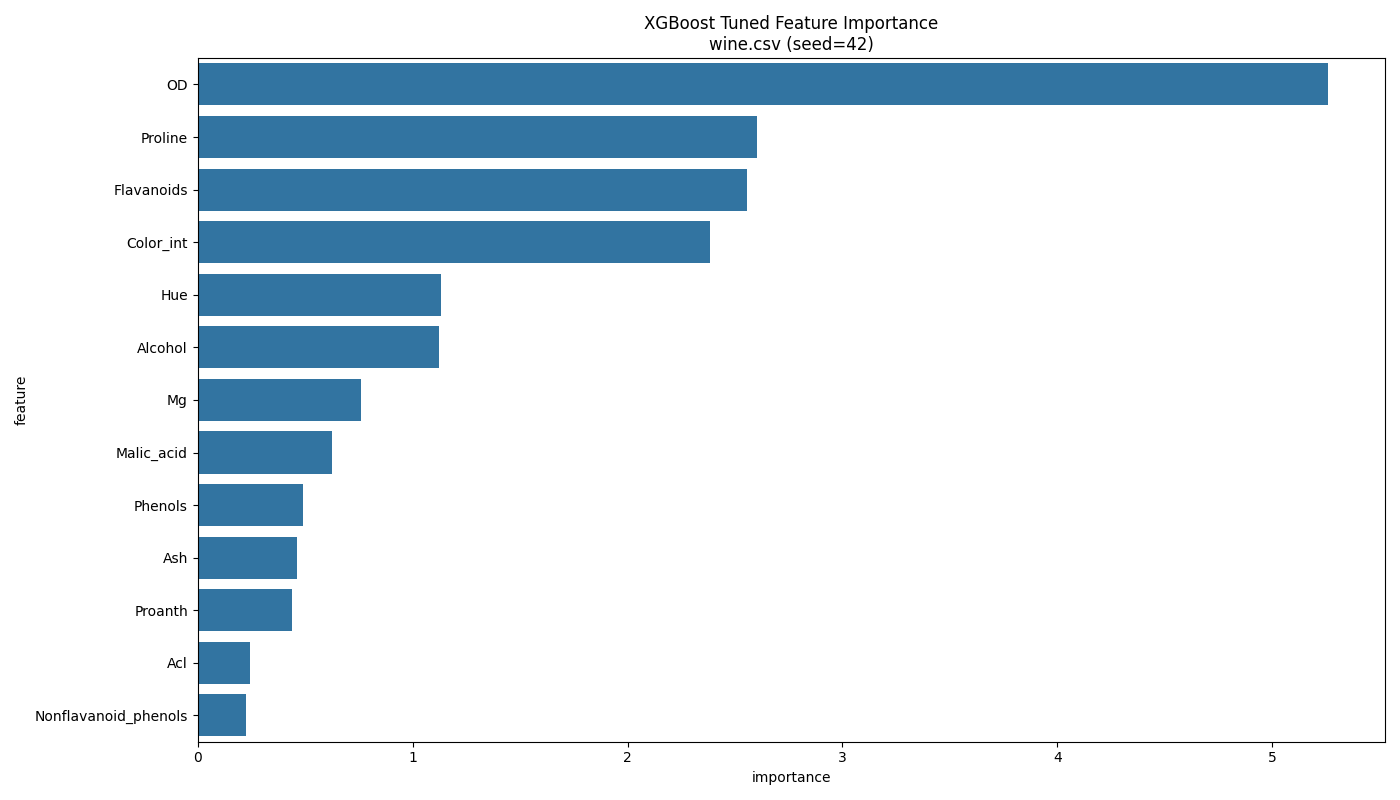

Feature Importance for wine (seed=123):


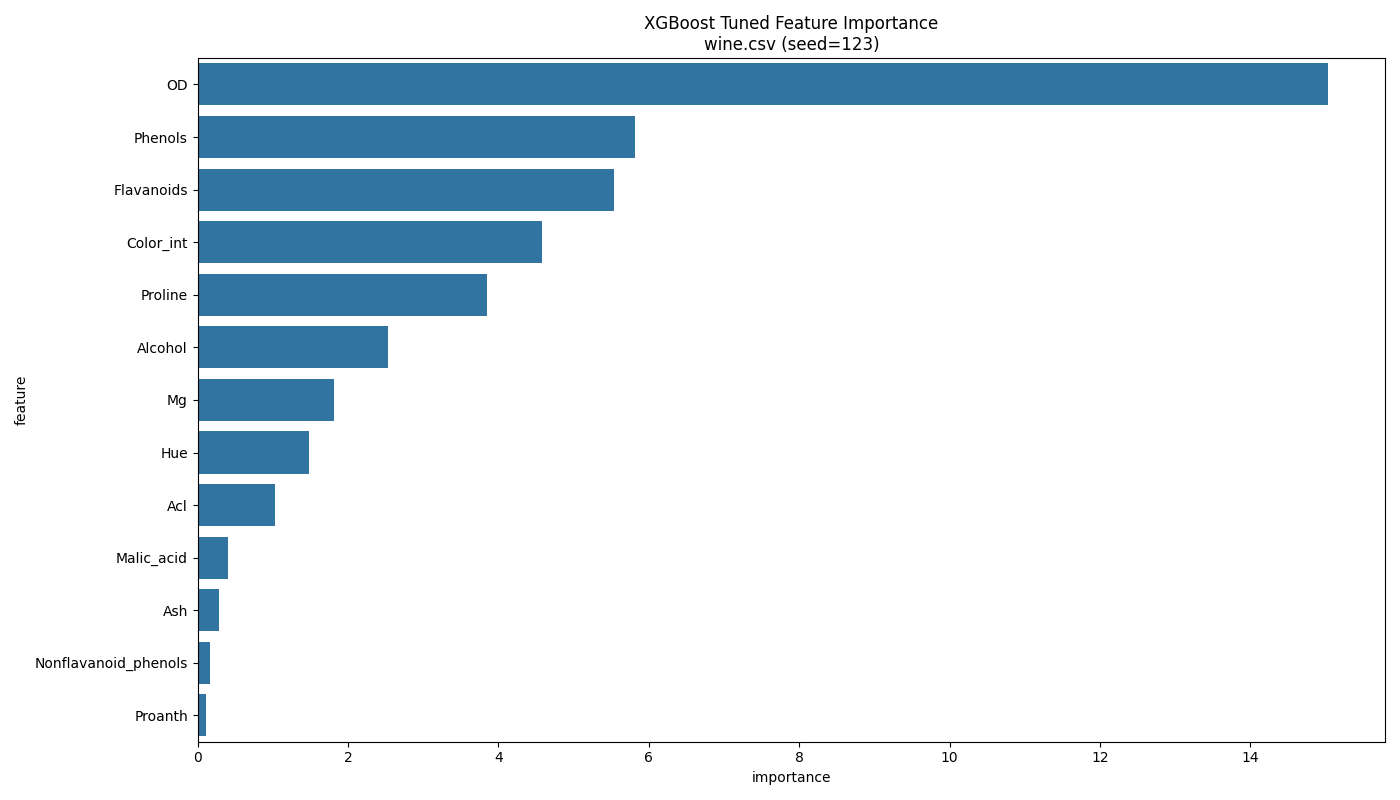

In [5]:
for dataset_name in data_dict_classification_only.keys():
    dataset_base = dataset_name.replace('.csv', '')
    
    csv_file1 = os.path.join(BOOSTINGS_TUNED_PATH, f"xgboost_tuned_{dataset_base}_summary.csv")
    csv_file2 = os.path.join(RUNTIME_MEMORY_TASK2_BOOSTINGS_TUNED_PATH, f"xgboost_tuned_{dataset_base}_runtime_memory_metrics.csv")

    print(f"CSV for {dataset_base}: xgboost_tuned_{dataset_base}_summary.csv")
    df1 = pd.read_csv(csv_file1)
    display(df1)

    print(f"CSV for {dataset_base}: xgboost_tuned_{dataset_base}_runtime_memory_metrics.csv")
    df2 = pd.read_csv(csv_file2)
    display(df2)

    for seed in RANDOM_SEEDS:
        img_path = os.path.join(FEATURE_IMPORTANCE_PATH, f"xgboost_importance_{dataset_base}_seed{seed}.png")
        if os.path.exists(img_path):
            print(f"Feature Importance for {dataset_base} (seed={seed}):")
            display(Image(filename=img_path))





In [6]:
# ---------------- Task 3+9 ----------------

from xgboost import XGBClassifier


def evaluate_cv_folds_xgboost(folds_dict):
    for dataset_file, folds_data in folds_dict.items():
        target_col = TARGET_COLS[dataset_file]
        summary = []
        runtime_memory_rows = []
        dataset_base = dataset_file.replace(".csv", "")

        for seed in RANDOM_SEEDS:
            np.random.seed(seed)
            random.seed(seed)
            fold_num = 1

            for fold_name, fold_splits in folds_data.items():
                df_train = fold_splits['train']
                df_val = fold_splits['val']

                X_train = df_train.drop(columns=[target_col])
                y_train = df_train[target_col]
                X_val = df_val.drop(columns=[target_col])
                y_val = df_val[target_col]

                temp_dir = tempfile.mkdtemp()

                start_time = time.time()
                model = XGBClassifier(random_state=seed, use_label_encoder=False, eval_metric='logloss', n_jobs=-1, enable_categorical=True)
                model.fit(X_train, y_train)
                results = evaluate_and_save_results_boosting(df_train, df_val, model, dataset_file)
                training_runtime_sec = round(time.time() - start_time, 3)

                infer_start = time.time()
                _ = model.predict(X_val)
                inference_time_per_sample = round((time.time() - infer_start) / len(X_val), 6)

                temp_model_file = os.path.join(temp_dir, f"{dataset_base}_{seed}_fold{fold_num}.pkl")
                with open(temp_model_file, "wb") as f:
                    pickle.dump(model, f)
                total_bytes = os.path.getsize(temp_model_file)
                model_size_mb = round(total_bytes / (1024 * 1024), 3)
                shutil.rmtree(temp_dir, ignore_errors=True)

                memory_usage_mb = get_memory_usage_mb()
                cpu_usage_percent = psutil.cpu_percent(interval=None)

                runtime_memory_rows.append({
                    "dataset": dataset_file,
                    "seed": seed,
                    "fold": fold_num,
                    "training_runtime_sec": training_runtime_sec,
                    "model_size_MB": model_size_mb,
                    "memory_usage_MB": memory_usage_mb,
                    "inference_time_per_sample_sec": inference_time_per_sample,
                    "cpu_usage_percent": cpu_usage_percent
                })

                summary.append({
                    "dataset": dataset_file,
                    "seed": seed,
                    "fold": fold_num,
                    **results,
                    "runtime": training_runtime_sec
                })

                fold_num += 1
                del model
                gc.collect()

        output_path = os.path.join(CV_FOLDS_METRICS_PATH, f"xgboost_{dataset_base}_cv_summary.csv")
        pd.DataFrame(summary).to_csv(output_path, index=False)

        task3_output_path = os.path.join(RUNTIME_MEMORY_TASK3_PATH, f"xgboost_{dataset_base}_task3_runtime_memory_metrics.csv")
        pd.DataFrame(runtime_memory_rows).to_csv(task3_output_path, index=False)

        json_path = os.path.join(RUNTIME_MEMORY_TASK3_PATH, f"xgboost_{dataset_base}_runtime_memory_metrics_cv_in_json.json")
        with open(json_path, 'w') as f:
            json.dump(runtime_memory_rows, f, indent=2)


evaluate_cv_folds_xgboost(folds_dict)


In [7]:
for dataset_name in data_dict_classification_only.keys():
    dataset_base = dataset_name.replace('.csv', '')
    csv_file1 = os.path.join(CV_FOLDS_METRICS_PATH, f"xgboost_{dataset_base}_cv_summary.csv")
    csv_file2 = os.path.join(RUNTIME_MEMORY_TASK3_PATH, f"xgboost_{dataset_base}_task3_runtime_memory_metrics.csv")

    print(f"CSV for {dataset_base}: xgboost_{dataset_base}_cv_summary.csv")
    df1 = pd.read_csv(csv_file1)
    display(df1)

    print(f"CSV for {dataset_base}: xgboost_{dataset_base}_task3_runtime_memory_metrics.csv")
    df2 = pd.read_csv(csv_file2)
    display(df2)



CSV for modeldata: xgboost_modeldata_cv_summary.csv


,dataset,seed,fold,accuracy,f1,precision,recall,runtime
0,modeldata.csv,42,1,0.930008,0.930174,0.930460,0.930008,1.059
1,modeldata.csv,42,2,0.929545,0.929736,0.930084,0.929545,1.021
2,modeldata.csv,42,3,0.931026,0.931204,0.931525,0.931026,1.290
3,modeldata.csv,42,4,0.926985,0.927205,0.927618,0.926985,1.034
4,modeldata.csv,42,5,0.934697,0.934774,0.934880,0.934697,1.052
5,modeldata.csv,123,1,0.930008,0.930174,0.930460,0.930008,1.025
6,modeldata.csv,123,2,0.929545,0.929736,0.930084,0.929545,1.030
7,modeldata.csv,123,3,0.931026,0.931204,0.931525,0.931026,1.048
8,modeldata.csv,123,4,0.926985,0.927205,0.927618,0.926985,1.036
9,modeldata.csv,123,5,0.934697,0.934774,0.934880,0.934697,1.039


CSV for modeldata: xgboost_modeldata_task3_runtime_memory_metrics.csv


,dataset,seed,fold,training_runtime_sec,model_size_MB,memory_usage_MB,inference_time_per_sample_sec,cpu_usage_percent
0,modeldata.csv,42,1,1.059,0.255,7862.926,0.000001,76.5
1,modeldata.csv,42,2,1.021,0.256,7842.684,0.000001,85.2
2,modeldata.csv,42,3,1.290,0.260,7833.141,0.000001,86.9
3,modeldata.csv,42,4,1.034,0.256,7826.062,0.000001,86.3
4,modeldata.csv,42,5,1.052,0.262,7834.062,0.000001,85.7
5,modeldata.csv,123,1,1.025,0.255,7902.785,0.000001,86.9
6,modeldata.csv,123,2,1.030,0.256,7906.016,0.000001,87.8
7,modeldata.csv,123,3,1.048,0.260,7829.273,0.000001,87.3
8,modeldata.csv,123,4,1.036,0.256,7902.105,0.000001,88.3
9,modeldata.csv,123,5,1.039,0.262,7830.047,0.000001,88.0


CSV for titanic: xgboost_titanic_cv_summary.csv


,dataset,seed,fold,accuracy,f1,precision,recall,runtime
0,titanic.csv,42,1,0.837989,0.836158,0.837067,0.837989,0.071
1,titanic.csv,42,2,0.786517,0.786517,0.786517,0.786517,0.072
2,titanic.csv,42,3,0.758427,0.757327,0.756672,0.758427,0.084
3,titanic.csv,42,4,0.792135,0.791189,0.790710,0.792135,0.072
4,titanic.csv,42,5,0.837079,0.835843,0.836001,0.837079,0.072
5,titanic.csv,123,1,0.837989,0.836158,0.837067,0.837989,0.072
6,titanic.csv,123,2,0.786517,0.786517,0.786517,0.786517,0.073
7,titanic.csv,123,3,0.758427,0.757327,0.756672,0.758427,0.073
8,titanic.csv,123,4,0.792135,0.791189,0.790710,0.792135,0.072
9,titanic.csv,123,5,0.837079,0.835843,0.836001,0.837079,0.072


CSV for titanic: xgboost_titanic_task3_runtime_memory_metrics.csv


,dataset,seed,fold,training_runtime_sec,model_size_MB,memory_usage_MB,inference_time_per_sample_sec,cpu_usage_percent
0,titanic.csv,42,1,0.071,0.450,7321.539,0.000022,92.8
1,titanic.csv,42,2,0.072,0.459,7322.742,0.000020,100.0
2,titanic.csv,42,3,0.084,0.416,7322.902,0.000022,100.0
3,titanic.csv,42,4,0.072,0.439,7322.133,0.000022,100.0
4,titanic.csv,42,5,0.072,0.488,7322.613,0.000020,100.0
5,titanic.csv,123,1,0.072,0.450,7322.875,0.000017,100.0
6,titanic.csv,123,2,0.073,0.459,7322.098,0.000022,100.0
7,titanic.csv,123,3,0.073,0.416,7321.328,0.000020,100.0
8,titanic.csv,123,4,0.072,0.439,7321.676,0.000017,100.0
9,titanic.csv,123,5,0.072,0.488,7321.734,0.000020,100.0


CSV for train: xgboost_train_cv_summary.csv


,dataset,seed,fold,accuracy,f1,precision,recall,runtime
0,train.csv,42,1,0.966667,0.966583,0.969697,0.966667,0.029
1,train.csv,42,2,0.966667,0.966583,0.969697,0.966667,0.028
2,train.csv,42,3,0.900000,0.895000,0.914141,0.900000,0.027
3,train.csv,42,4,0.966667,0.966583,0.969697,0.966667,0.028
4,train.csv,42,5,0.900000,0.899749,0.902357,0.900000,0.026
5,train.csv,123,1,0.966667,0.966583,0.969697,0.966667,0.028
6,train.csv,123,2,0.966667,0.966583,0.969697,0.966667,0.028
7,train.csv,123,3,0.900000,0.895000,0.914141,0.900000,0.028
8,train.csv,123,4,0.966667,0.966583,0.969697,0.966667,0.029
9,train.csv,123,5,0.900000,0.899749,0.902357,0.900000,0.026


CSV for train: xgboost_train_task3_runtime_memory_metrics.csv


,dataset,seed,fold,training_runtime_sec,model_size_MB,memory_usage_MB,inference_time_per_sample_sec,cpu_usage_percent
0,train.csv,42,1,0.029,0.231,7322.641,0.000033,100.0
1,train.csv,42,2,0.028,0.228,7322.762,0.000000,100.0
2,train.csv,42,3,0.027,0.223,7323.199,0.000033,100.0
3,train.csv,42,4,0.028,0.230,7323.320,0.000033,100.0
4,train.csv,42,5,0.026,0.221,7323.320,0.000033,100.0
5,train.csv,123,1,0.028,0.231,7323.320,0.000033,100.0
6,train.csv,123,2,0.028,0.228,7323.320,0.000033,100.0
7,train.csv,123,3,0.028,0.223,7323.320,0.000033,100.0
8,train.csv,123,4,0.029,0.230,7323.320,0.000033,100.0
9,train.csv,123,5,0.026,0.221,7323.320,0.000033,100.0


CSV for wine: xgboost_wine_cv_summary.csv


,dataset,seed,fold,accuracy,f1,precision,recall,runtime
0,wine.csv,42,1,0.972222,0.972369,0.974747,0.972222,0.037
1,wine.csv,42,2,0.972222,0.971970,0.974074,0.972222,0.031
2,wine.csv,42,3,0.972222,0.972369,0.974747,0.972222,0.032
3,wine.csv,42,4,0.914286,0.913174,0.914545,0.914286,0.033
4,wine.csv,42,5,1.000000,1.000000,1.000000,1.000000,0.031
5,wine.csv,123,1,0.972222,0.972369,0.974747,0.972222,0.032
6,wine.csv,123,2,0.972222,0.971970,0.974074,0.972222,0.038
7,wine.csv,123,3,0.972222,0.972369,0.974747,0.972222,0.032
8,wine.csv,123,4,0.914286,0.913174,0.914545,0.914286,0.031
9,wine.csv,123,5,1.000000,1.000000,1.000000,1.000000,0.040


CSV for wine: xgboost_wine_task3_runtime_memory_metrics.csv


,dataset,seed,fold,training_runtime_sec,model_size_MB,memory_usage_MB,inference_time_per_sample_sec,cpu_usage_percent
0,wine.csv,42,1,0.037,0.217,7323.621,0.000042,100.0
1,wine.csv,42,2,0.031,0.215,7323.965,0.000028,100.0
2,wine.csv,42,3,0.032,0.217,7323.965,0.000028,100.0
3,wine.csv,42,4,0.033,0.215,7323.965,0.000029,100.0
4,wine.csv,42,5,0.031,0.218,7323.980,0.000043,100.0
5,wine.csv,123,1,0.032,0.217,7323.980,0.000000,100.0
6,wine.csv,123,2,0.038,0.215,7323.980,0.000028,100.0
7,wine.csv,123,3,0.032,0.217,7323.980,0.000028,100.0
8,wine.csv,123,4,0.031,0.215,7323.980,0.000057,100.0
9,wine.csv,123,5,0.040,0.218,7323.980,0.000029,100.0


In [2]:
# ---------------- Task 6 ----------------

from xgboost import XGBClassifier

def evaluate_pipeline_folds_times_xgboost(final_output):

    for dataset_name, folds in final_output.items():
        dataset_base = dataset_name.replace('.csv', '')

        dataset_summary = []
        time_log_rows = []

        target_col = TARGET_COLS[dataset_name]

        for seed in RANDOM_SEEDS_PIPELINE:

            np.random.seed(seed)
            random.seed(seed)

            for fold_name, split in folds.items():

                df_train = split['train'].copy()
                df_val = split['val'].copy()
                pipe_times = split['pipeline_time']
                pipe_times_copy = pipe_times.copy()
                pipe_times_copy["total_time"] = sum(pipe_times_copy.values())

                X_train = df_train.drop(columns=[target_col])
                y_train = df_train[target_col]

                X_val = df_val.drop(columns=[target_col])
                y_val = df_val[target_col]

                temp_dir = tempfile.mkdtemp()
                start = time.time()

                num_classes = len(np.unique(y_train))

                model = XGBClassifier(
                    random_state=seed,
                    n_estimators=5000,
                    learning_rate=0.05,
                    max_depth=7,
                    subsample=0.9,
                    colsample_bytree=0.9,
                    objective="multi:softprob" if num_classes > 2 else "binary:logistic",
                    eval_metric="logloss"
                )

                model.fit(X_train, y_train)
                preds = model.predict(X_val)

                runtime = round(time.time() - start, 3)
                fold_idx = int(fold_name.split("_")[1])

                best_model = "XGBoost"

                dataset_summary.append({
                    "dataset": dataset_name,
                    "seed": seed,
                    "fold": fold_idx,
                    "model_name": best_model,
                    "accuracy": (accuracy_score(y_val, preds)),
                    "f1": (f1_score(y_val, preds, average='weighted')),
                    "precision": (precision_score(y_val, preds, average='weighted')),
                    "recall": (recall_score(y_val, preds, average='weighted')),
                    "runtime": runtime
                })

                row = {"dataset": dataset_name, "fold": fold_idx, "model_name": best_model}
                row.update(pipe_times_copy)
                time_log_rows.append(row)

                shutil.rmtree(temp_dir, ignore_errors=True)

        df_summary = pd.DataFrame(dataset_summary).drop_duplicates()
        df_times = pd.DataFrame(time_log_rows).drop_duplicates()

        df_summary = df_summary.sort_values(["dataset", "seed", "fold"])
        df_times = df_times.sort_values(["dataset", "fold"])

        summary_path = os.path.join(
            PIPELINE_DATAFRAMES_METRICS_PATH,
            f"xgboost_{dataset_base}_pipeline_summary.csv"
        )
        df_summary.to_csv(summary_path, index=False)

        time_log_path = os.path.join(
            PIPELINE_LOG_TIMES_PATH,
            f"xgboost_{dataset_base}_pipeline_time_log.csv"
        )
        df_times.to_csv(time_log_path, index=False)


evaluate_pipeline_folds_times_xgboost(run_pipeline_on_folds_with_control(pipeline_data_dict))


In [3]:
for dataset_name in data_dict_classification_only.keys():
    dataset_base = dataset_name.replace('.csv', '')
    
    csv_file_1 = os.path.join(PIPELINE_DATAFRAMES_METRICS_PATH, f"xgboost_{dataset_base}_pipeline_summary.csv")
    csv_file_2 = os.path.join(PIPELINE_LOG_TIMES_PATH, f"xgboost_{dataset_base}_pipeline_time_log.csv")
    
    df1 = pd.read_csv(csv_file_1)
    df2 = pd.read_csv(csv_file_2)
    
    print(f"CSV for {dataset_base}: xgboost_{dataset_base}_pipeline_summary.csv")
    display(df1) 
    print(f"CSV for {dataset_base}: xgboost_{dataset_base}_pipeline_time_log.csv")
    display(df2) 



CSV for modeldata: xgboost_modeldata_pipeline_summary.csv


,dataset,seed,fold,model_name,accuracy,f1,precision,recall,runtime
0,modeldata.csv,42,1,XGBoost,0.915874,0.915811,0.915759,0.915874,20.240
1,modeldata.csv,42,2,XGBoost,0.920439,0.920515,0.920610,0.920439,16.554
2,modeldata.csv,123,1,XGBoost,0.915948,0.915873,0.915813,0.915948,16.155
3,modeldata.csv,123,2,XGBoost,0.920526,0.920588,0.920663,0.920526,16.892


CSV for modeldata: xgboost_modeldata_pipeline_time_log.csv


,dataset,fold,model_name,preprocessing,nan_guard_before_vif,vif,binner,nan_guard_before_poly,selector,total_time
0,modeldata.csv,1,XGBoost,0.448909,0.196688,0.018363,0.080946,0.055532,0.025147,0.825585
1,modeldata.csv,2,XGBoost,0.389587,0.133581,0.016140,0.051558,0.045593,0.024567,0.661027


CSV for titanic: xgboost_titanic_pipeline_summary.csv


,dataset,seed,fold,model_name,accuracy,f1,precision,recall,runtime
0,titanic.csv,42,1,XGBoost,0.791480,0.787042,0.789874,0.791480,1.610
1,titanic.csv,42,2,XGBoost,0.820225,0.813217,0.826517,0.820225,1.475
2,titanic.csv,123,1,XGBoost,0.798206,0.793339,0.797493,0.798206,1.355
3,titanic.csv,123,2,XGBoost,0.820225,0.813217,0.826517,0.820225,1.383


CSV for titanic: xgboost_titanic_pipeline_time_log.csv


,dataset,fold,model_name,preprocessing,nan_guard_before_vif,vif,binner,nan_guard_before_poly,poly,selector,total_time
0,titanic.csv,1,XGBoost,0.006394,0.001005,0.0,0.001002,0.001002,0.010050,0.002005,0.021459
1,titanic.csv,2,XGBoost,0.007112,0.001002,0.0,0.001002,0.001002,0.008019,0.002042,0.020180


CSV for train: xgboost_train_pipeline_summary.csv


,dataset,seed,fold,model_name,accuracy,f1,precision,recall,runtime
0,train.csv,42,1,XGBoost,0.946667,0.946581,0.948470,0.946667,1.138
1,train.csv,42,2,XGBoost,0.906667,0.904820,0.907316,0.906667,1.238
2,train.csv,123,1,XGBoost,0.946667,0.946581,0.948470,0.946667,1.152
3,train.csv,123,2,XGBoost,0.906667,0.904820,0.907316,0.906667,1.223


CSV for train: xgboost_train_pipeline_time_log.csv


,dataset,fold,model_name,preprocessing,nan_guard_before_vif,vif,binner,nan_guard_before_poly,poly,selector,total_time
0,train.csv,1,XGBoost,0.001002,0.000000,0.001002,0.0,0.0,0.0,0.0,0.002004
1,train.csv,2,XGBoost,0.001002,0.001002,0.000000,0.0,0.0,0.0,0.0,0.002004


CSV for wine: xgboost_wine_pipeline_summary.csv


,dataset,seed,fold,model_name,accuracy,f1,precision,recall,runtime
0,wine.csv,42,1,XGBoost,0.932584,0.932638,0.933011,0.932584,1.068
1,wine.csv,42,2,XGBoost,0.853933,0.854725,0.861554,0.853933,1.097
2,wine.csv,123,1,XGBoost,0.932584,0.932638,0.933011,0.932584,1.059
3,wine.csv,123,2,XGBoost,0.853933,0.854725,0.861554,0.853933,1.065


CSV for wine: xgboost_wine_pipeline_time_log.csv


,dataset,fold,model_name,preprocessing,nan_guard_before_vif,vif,binner,nan_guard_before_poly,poly,selector,total_time
0,wine.csv,1,XGBoost,0.002069,0.0,0.0,0.0,0.001005,0.0,0.0,0.003074
1,wine.csv,2,XGBoost,0.002013,0.0,0.0,0.0,0.001002,0.0,0.0,0.003015
